### Problem2.1

- **ROC Curve:** TPR/FPR. True negatives (TN) matter because the false positive rate (FPR) depends on TN:
  $$
  \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
  $$
  The ROC curve plots the true positive rate (TPR) against FPR, so TN is essential for computing FPR.

- **PR Curve:** True negatives do not matter. The PR curve uses precision and recall, which depend on true positives (TP), false positives (FP), and false negatives (FN):
  $$
  \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
  $$
  $$
  \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  $$


Each point on the ROC curve corresponds to a unique point on the PR curve because both curves are based on the same TP, FP, FN, TN. For any decision threshold, the counts of TP, FP, FN, and TN are fixed, producing both an ROC and a PR point. So while ROC curves are used for balanced data, PR curves are used for imbalanced data, however their metrics are based on the same counts of TP, FP, FN, TN.


/Users/bytedance/Documents/anaconda3/envs/COMS6998/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


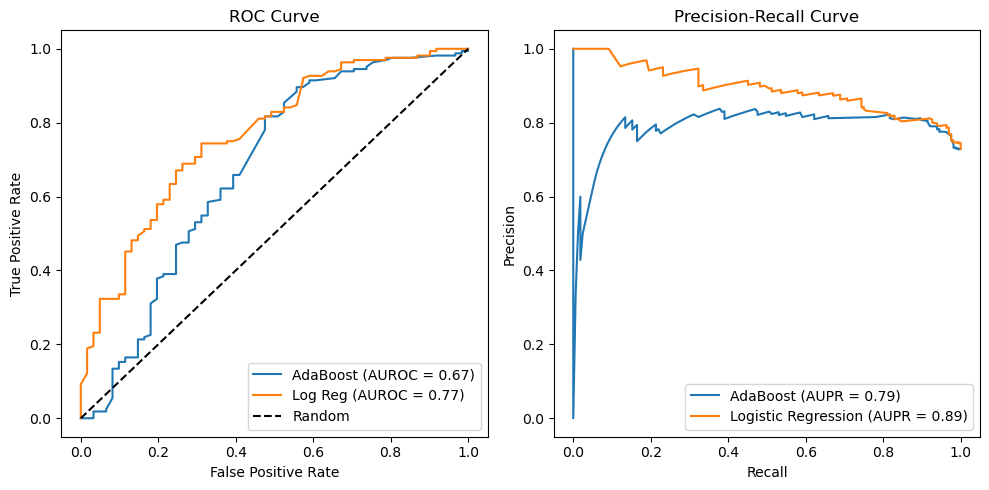

All-positive classifier ROC point: (1.0, 0.7288888888888889)
All-positive classifier PR point: Precision = 0.7288888888888889, Recall = 1.0


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, auc

X, y = fetch_openml(name='blood-transfusion-service-center', version=1, as_frame=True, return_X_y=True)
y = y.astype(int).replace({2: 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
logreg = LogisticRegression(solver='liblinear')

ada.fit(X_train, y_train)
logreg.fit(X_train, y_train)


ada_probs = ada.predict_proba(X_test)[:, 1]
logreg_probs = logreg.predict_proba(X_test)[:, 1]

# Generate ROC/ PR curves
fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_probs)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)

precision_ada, recall_ada, _ = precision_recall_curve(y_test, ada_probs)
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, logreg_probs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUROC = {auc(fpr_ada, tpr_ada):.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Log Reg (AUROC = {auc(fpr_logreg, tpr_logreg):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_ada, precision_ada, label=f'AdaBoost (AUPR = {auc(recall_ada, precision_ada):.2f})')
plt.plot(recall_logreg, precision_logreg, label=f'Logistic Regression (AUPR = {auc(recall_logreg, precision_logreg):.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()


plt.tight_layout()
plt.show()

all_pos = sum(y_test == 1) / len(y_test)
print(f"All-positive classifier ROC point: (1.0, {all_pos})")
print(f"All-positive classifier PR point: Precision = {all_pos}, Recall = 1.0")


In [21]:
def prg_curve(precision, recall, pi, epsilon=1e-10):
    precision_gain = np.where(precision < 1, (precision - pi) / (pi * (1 - precision + epsilon)), 1)
    recall_gain = np.where(recall < 1, (recall - pi) / (pi * (1 - recall + epsilon)), 1)
    return precision_gain, recall_gain

precision_gain_ada, recall_gain_ada = prg_curve(precision_ada, recall_ada, pi)

precision_gain_logreg, recall_gain_logreg = prg_curve(precision_logreg, recall_logreg, pi)


sorted_indices_ada = np.argsort(recall_gain_ada)
recall_gain_ada_sorted = recall_gain_ada[sorted_indices_ada]
precision_gain_ada_sorted = precision_gain_ada[sorted_indices_ada]


sorted_indices_logreg = np.argsort(recall_gain_logreg)
recall_gain_logreg_sorted = recall_gain_logreg[sorted_indices_logreg]
precision_gain_logreg_sorted = precision_gain_logreg[sorted_indices_logreg]

auprg_ada = auc(recall_gain_ada_sorted, precision_gain_ada_sorted)
auprg_logreg = auc(recall_gain_logreg_sorted, precision_gain_logreg_sorted)

print(f"AdaBoost - AUROC: {auroc_ada:.3f}, AUPR: {aupr_ada:.3f}, AUPRG: {auprg_ada:.3f}")
print(f"Logistic Regression - AUROC: {auroc_logreg:.3f}, AUPR: {aupr_logreg:.3f}, AUPRG: {auprg_logreg:.3f}")


AdaBoost - AUROC: 0.674, AUPR: 0.786, AUPRG: 6.425
Logistic Regression - AUROC: 0.767, AUPR: 0.892, AUPRG: 13.128


The PR Gain curves provide a more meaningful assessment than standard PR curves in cases of imbalanced data, as they account for the base rate. In this case, LR outperformed AdaBoost across all metrics. The significantly higher AUPRG for LR (13.128) compared to AdaBoost (6.425) highlights that it is better suited for this task when considering the base rate. Therefore I agree with the NIPS paper's conclusion that practitioners should prefer PR Gain curves over PR curves for more accurate evaluation of model performance.